In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from segmentation.fuzzy_c_means import FuzzyCMeansSegmenter
from filtering.kalman_filter import KalmanFilter
from filtering.lowpass_filter import LowPassFilter
from os import listdir

In [2]:
folder_path = "/workspaces/python-opencv/resources/VisDrone2019-SOT-train/sequences/uav0000169_00000_s/"
out_path = "/workspaces/python-opencv/repo/out/sequence.mp4"

In [3]:
pictures = sorted(listdir(folder_path))
fps = 30

In [4]:
frame = cv.imread(folder_path + pictures[0])

In [5]:
x, y, w, h = 625, 425, 30, 40

In [6]:
track_window = (x, y, w, h)

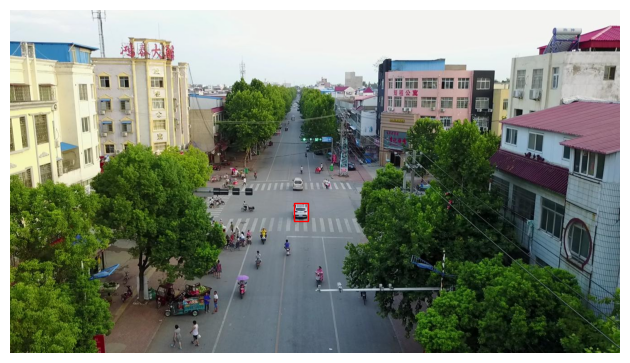

In [7]:
fig, ax = plt.subplots()
plt.imshow(frame[:, :, ::-1])
rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.axis("off")
plt.tight_layout()
plt.show()

In [8]:
roi = frame[y:y+h, x:x+w, :]

histogram_region = roi
histogram_region_hsv = cv.cvtColor(histogram_region, cv.COLOR_BGR2HSV) 

In [9]:
fuzzy = FuzzyCMeansSegmenter(5, 0, 2, 2, 2, 100)
segmented, centroids = fuzzy.segment_image(histogram_region_hsv, return_centroid=True)

subset_segmented = segmented[int(h/4):int(3 * h/4), int(w/4):int(3 * w/4)]
# subset_segmented = segmented

counts = np.bincount(subset_segmented.flatten())
dominant_index = np.argmax(counts)
dominant_color = centroids[dominant_index]

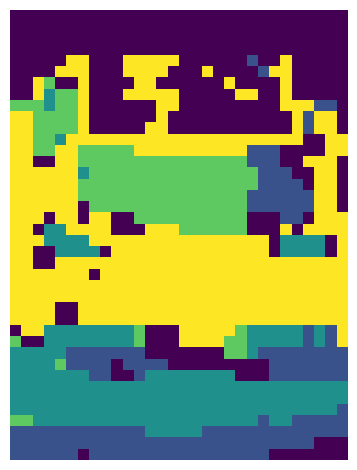

In [10]:
plt.imshow(segmented)
plt.axis("off")
plt.tight_layout()
plt.show()

In [11]:
_h, _s, _v = dominant_color
std_h, std_s, std_v = np.std(histogram_region_hsv, axis=(0, 1))

std_v = 30
_v = 230

lower_bound = np.array([max(_h - std_h, 0), max(_s - std_s, 0), max(_v - std_v, 0)])
upper_bound = np.array([min(_h + std_h, 180), min(_s + std_s, 255), min(_v + std_v, 255)])

print(lower_bound)
print(upper_bound)

[ 98.15276248   0.         200.        ]
[117.47185774  74.83640905 255.        ]


In [12]:
img_hsv_roi = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
img_mask = cv.inRange(img_hsv_roi, lower_bound, upper_bound)

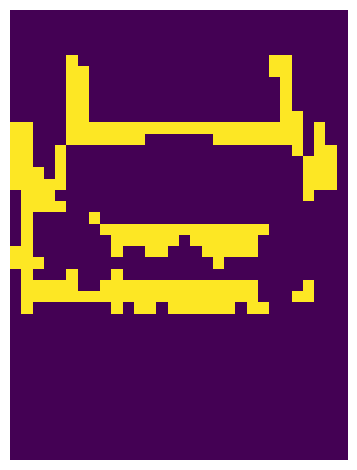

In [13]:
plt.imshow(img_mask)
plt.axis("off")
plt.tight_layout()
plt.show()

In [14]:
roi_hist = cv.calcHist([img_hsv_roi], [0], img_mask, [180], [0, 180])
roi_hist = cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)

In [15]:
fourcc = cv.VideoWriter_fourcc(*'mp4v')
video_out = cv.VideoWriter(out_path, fourcc, fps, frame.shape[0:2][::-1]) 

In [16]:
term_crit = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1)

In [17]:
for picture in pictures:
    frame = cv.imread(folder_path + picture)

    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    dst = cv.calcBackProject([hsv], [0], roi_hist, [0, 180], 1)

    # apply meanshift to get the new location
    ret, track_window = cv.meanShift(dst, track_window, term_crit)

    # Draw it on image
    x, y, w, h = track_window
    img2 = cv.rectangle(frame, (x, y), (x+w, y+h), 255, 2)
    
    video_out.write(img2)

In [18]:
video_out.release()
cv.destroyAllWindows()